In [2]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as data_reader
import datetime
import ta
from sklearn import preprocessing, linear_model, metrics, neighbors, feature_selection, ensemble, multioutput, svm, model_selection
from statsmodels import regression

In [3]:
orig_appl = data_reader.get_data_yahoo('AAPL', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))
orig_spy = data_reader.get_data_yahoo('SPY', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))

In [4]:
appl = orig_appl.copy()
spy = orig_spy.copy()

In [5]:
appl.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4680.000000,4680.000000,4680.000000,4680.000000,4.680000e+03,4680.000000
mean,59.227883,58.098642,58.676359,58.677083,1.165798e+08,54.727269
std,60.710405,59.693577,60.194961,60.212747,9.681992e+07,58.504425
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409
25%,6.736786,6.598214,6.663571,6.643214,4.818730e+07,5.780266
50%,35.111429,34.330713,34.683571,34.713572,8.871345e+07,30.204314
75%,99.892502,98.042501,98.682501,98.782499,1.540704e+08,91.709465
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798


In [7]:
appl.dropna(inplace=True)
spy.dropna(inplace=True)

In [8]:
return_appl = appl['Adj Close'].pct_change()[1:]
return_spy = spy['Adj Close'].pct_change()[1:]

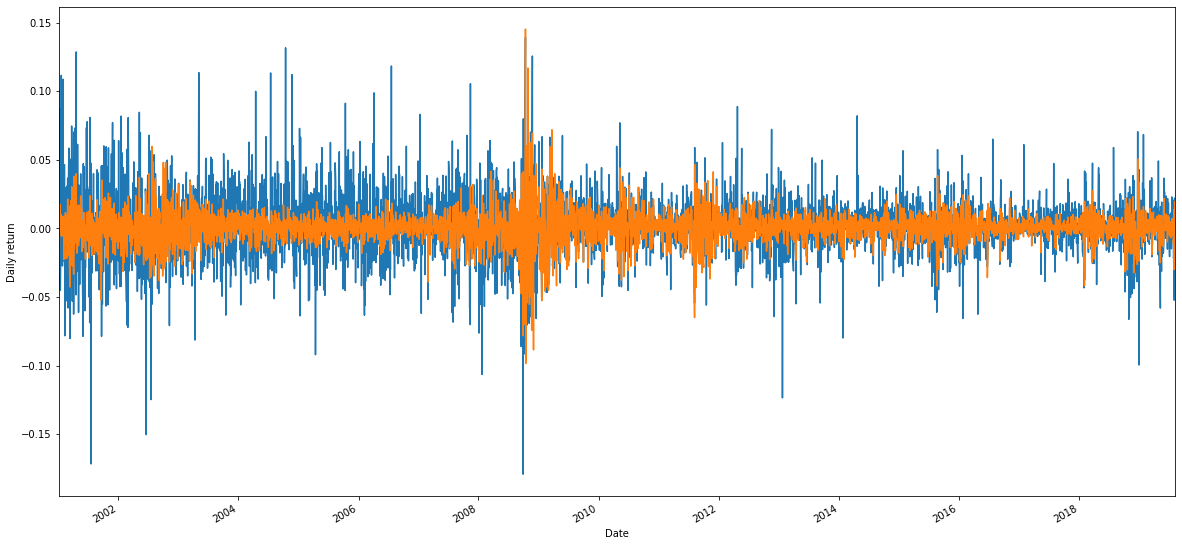

In [9]:
plt.figure(figsize=(20,10))
return_appl.plot()
return_spy.plot()
plt.ylabel("Daily return") 
plt.show()

In [10]:
def calculate_alpha_and_beta(x, y, periods):
    x_values = x['Adj Close'].pct_change()[1:].values
    y_values = y['Adj Close'].pct_change()[1:].values
    
    betas = [None for index in range(periods + 1)]
    alphas = [None for index in range(periods + 1)]
    
    for index in range(len(x_values) - periods):
        X = x_values[index: (index + periods)]
        Y = y_values[index: (index + periods)]

        X = sm.add_constant(X)
        model = regression.linear_model.OLS(Y, X).fit()
        
        alphas.append(model.params[0])
        betas.append(model.params[1])

    y['alpha'] = np.array(alphas) 
    y['beta'] = np.array(betas) 
        
    return y.copy()

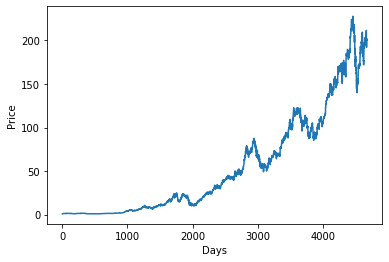

In [13]:
plt.plot(range(len(appl)), appl["Adj Close"])
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

In [349]:
appl = calculate_alpha_and_beta(spy, appl, 64)

In [398]:
def fourier_transforms(data, numbers):
    close_fft = np.fft.fft(np.asarray(data['Adj Close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_list = np.asarray(fft_df['fft'].tolist())

    for num_ in [3, 6, 9, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        data['Fourier_{}'.format(num_)] = np.fft.ifft(fft_list_m10)
    
    return data

In [350]:
def get_technical_indicators(dataset, spy):
    # Assuming 0 for now
    daily_rf_rate = 0
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Adj Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Adj Close'].rolling(window=21).mean()
    dataset['SMA100'] = dataset['Adj Close'].rolling(window=100).mean()

    # Create MACD
    dataset['26ema'] = dataset['Adj Close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['Adj Close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Adj Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Adj Close'].ewm(span=100).mean()
    dataset['ROC'] = ((dataset['Adj Close'] - dataset['Adj Close'].shift(100)) / dataset['Adj Close'].shift(100)) * 100
    dataset['SPY_SMA_100'] = spy['Adj Close'].rolling(window=100).mean()
    
    # Compute Volatility on spy and index 
    dataset['SPY_Vol'] = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1)).rolling(window=60).std() * np.sqrt(252)
    dataset['Log_Returns'] = np.log(dataset['Adj Close'] / dataset['Adj Close'].shift(1))
    dataset['Vol'] = dataset['Log_Returns'].rolling(window=60).std() * np.sqrt(252)
    dataset['Sharpe_Ratio'] = (dataset['Log_Returns'].rolling(window=60).mean() - daily_rf_rate) / dataset['Vol']
    
    return dataset

In [351]:
 def variables_correlation(data):
        plt.figure(figsize=(18,14))
        cor = data.corr()
        sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()

In [352]:
appl = get_technical_indicators(appl, spy)
appl.dropna(inplace=True)
appl.describe()

,High,Low,Open,Close,Volume,Adj Close,ma7,ma21,SMA100,26ema,...,20sd,upper_band,lower_band,ema,ROC,SPY_SMA_100,SPY_Vol,Log_Returns,Vol,Sharpe_Ratio
count,4580.000000,4580.000000,4580.000000,4580.000000,4.580000e+03,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,...,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000
mean,60.487236,59.335435,59.924770,59.925416,1.164906e+08,55.893626,55.764288,55.454240,53.776219,55.347813,...,1.591247,58.636733,52.271747,53.807112,14.830453,132.366011,0.161155,0.001077,0.332192,0.004629
std,60.761875,59.745607,60.246235,60.264470,9.744216e+07,58.598945,58.484502,58.197130,56.667325,58.062855,...,1.876879,61.277489,55.200205,56.621128,27.280823,61.390064,0.095472,0.022293,0.129037,0.008704
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409,0.827306,0.860453,0.896770,0.863244,...,0.015558,0.924447,0.671332,0.902513,-54.964303,63.017444,0.049786,-0.197470,0.103573,-0.018383
25%,8.627857,8.337857,8.528214,8.508929,4.727588e+07,7.403627,7.291623,7.253475,6.842763,7.369599,...,0.269071,7.888846,6.567145,7.112726,-0.911313,86.056159,0.106341,-0.009538,0.232196,-0.001384
50%,37.124287,36.366428,36.719286,36.752857,8.821820e+07,31.978696,31.718377,31.699938,30.050067,31.570441,...,0.986109,33.394677,29.531916,30.167419,13.890772,107.866123,0.130904,0.000942,0.310198,0.004718
75%,100.725718,98.852497,99.842501,99.962143,1.544265e+08,92.593307,92.472814,92.083176,94.224057,92.388400,...,2.198864,96.162370,87.645340,94.767155,28.689641,182.095063,0.190176,0.012190,0.402581,0.010534
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798,223.224060,219.401228,205.928441,218.637046,...,15.069447,228.119122,211.761917,205.801093,141.700234,287.762976,0.755843,0.130194,0.931176,0.033084


In [279]:
print(appl.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'alpha', 'beta',
       'ma7', 'ma21', 'SMA100', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'ROC', 'SPY_SMA_100', 'SPY_Vol', 'Log_Returns',
       'Vol', 'Sharpe_Ratio'],
      dtype='object')


In [353]:
appl['close'] = appl['Adj Close']
appl = appl.drop(['Adj Close', 'Close', 'Volume'], axis=1)
#appl = appl.drop(['Adj Close', 'Close', 'Volume'], axis=1)

In [292]:
appl['alpha'].describe()

count     4580.000000
unique    4580.000000
top          0.000771
freq         1.000000
Name: alpha, dtype: float64

In [293]:
appl['beta'].describe()

count     4580.000000
unique    4580.000000
top          1.040408
freq         1.000000
Name: beta, dtype: float64

In [354]:
columns = list(appl.columns)
print(columns)

['High', 'Low', 'Open', 'alpha', 'beta', 'ma7', 'ma21', 'SMA100', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'ROC', 'SPY_SMA_100', 'SPY_Vol', 'Log_Returns', 'Vol', 'Sharpe_Ratio', 'close']


In [295]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4580 entries, 2001-05-25 to 2019-08-09
Data columns (total 22 columns):
High            4580 non-null float64
Low             4580 non-null float64
Open            4580 non-null float64
alpha           4580 non-null object
beta            4580 non-null object
ma7             4580 non-null float64
ma21            4580 non-null float64
SMA100          4580 non-null float64
26ema           4580 non-null float64
12ema           4580 non-null float64
MACD            4580 non-null float64
20sd            4580 non-null float64
upper_band      4580 non-null float64
lower_band      4580 non-null float64
ema             4580 non-null float64
ROC             4580 non-null float64
SPY_SMA_100     4580 non-null float64
SPY_Vol         4580 non-null float64
Log_Returns     4580 non-null float64
Vol             4580 non-null float64
Sharpe_Ratio    4580 non-null float64
close           4580 non-null float64
dtypes: float64(20), object(2)
memory usa

In [355]:
appl['alpha'] = appl['alpha'].astype(np.float64)

In [356]:
appl['beta'] = appl['beta'].astype(np.float64)

In [357]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4580 entries, 2001-05-25 to 2019-08-09
Data columns (total 22 columns):
High            4580 non-null float64
Low             4580 non-null float64
Open            4580 non-null float64
alpha           4580 non-null float64
beta            4580 non-null float64
ma7             4580 non-null float64
ma21            4580 non-null float64
SMA100          4580 non-null float64
26ema           4580 non-null float64
12ema           4580 non-null float64
MACD            4580 non-null float64
20sd            4580 non-null float64
upper_band      4580 non-null float64
lower_band      4580 non-null float64
ema             4580 non-null float64
ROC             4580 non-null float64
SPY_SMA_100     4580 non-null float64
SPY_Vol         4580 non-null float64
Log_Returns     4580 non-null float64
Vol             4580 non-null float64
Sharpe_Ratio    4580 non-null float64
close           4580 non-null float64
dtypes: float64(22)
memory usage: 823.0

In [358]:
appl.dropna(inplace=True)

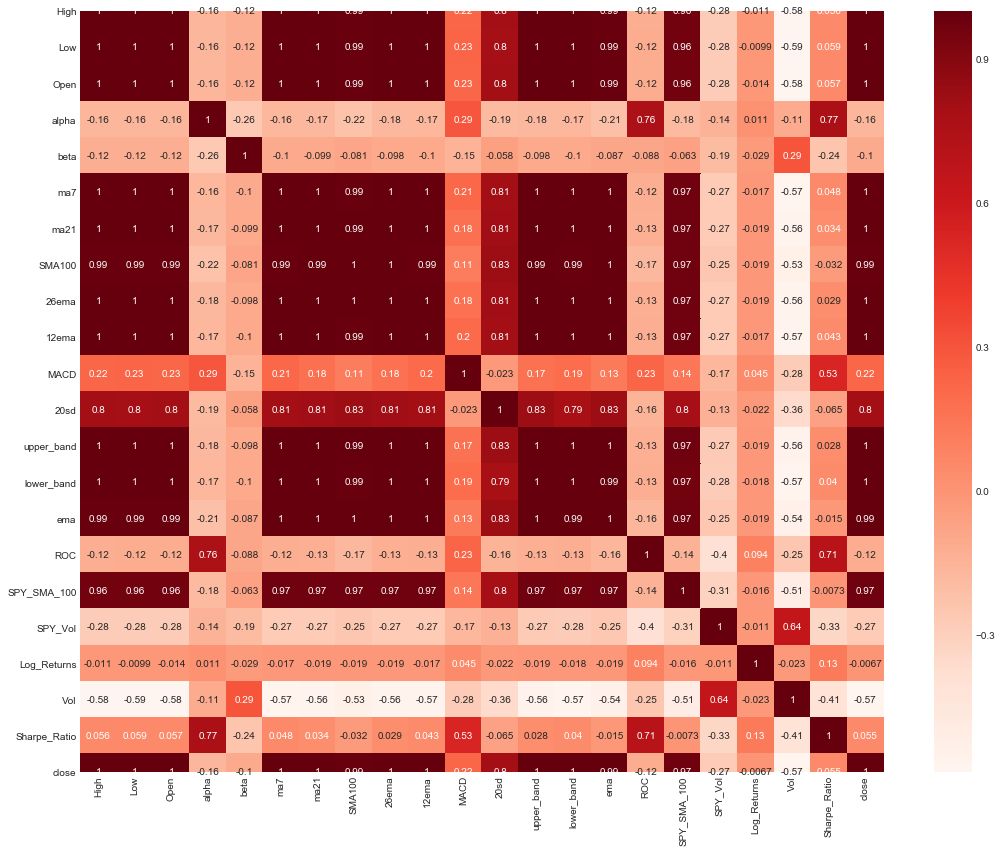

In [359]:
variables_correlation(appl)

In [360]:
appl = appl.drop(['High', 'Low', 'Open'], axis=1)

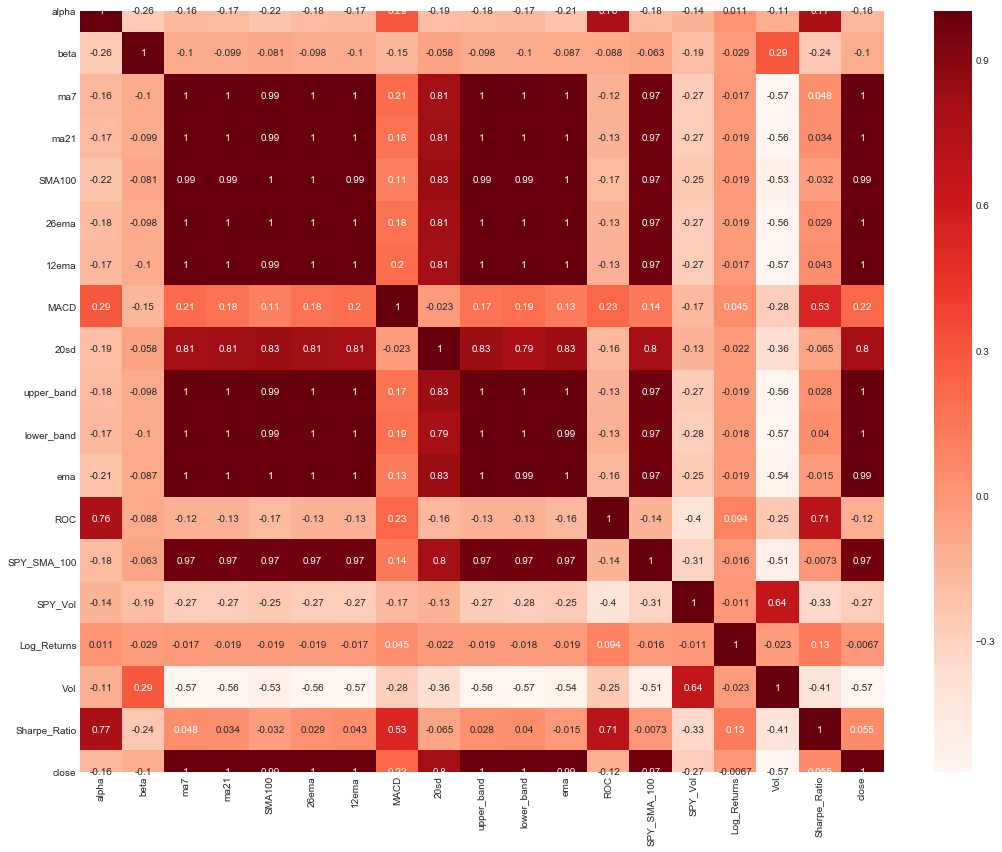

In [361]:
variables_correlation(appl)

In [362]:
appl = appl.drop(['Sharpe_Ratio', 'ma7', 'ma21', 'SPY_Vol', 'upper_band', 'lower_band', 'Vol', 'ema', '20sd', 'ROC', '26ema', 'SPY_SMA_100'], axis=1)
# TODO: Log_returns and Vol ??

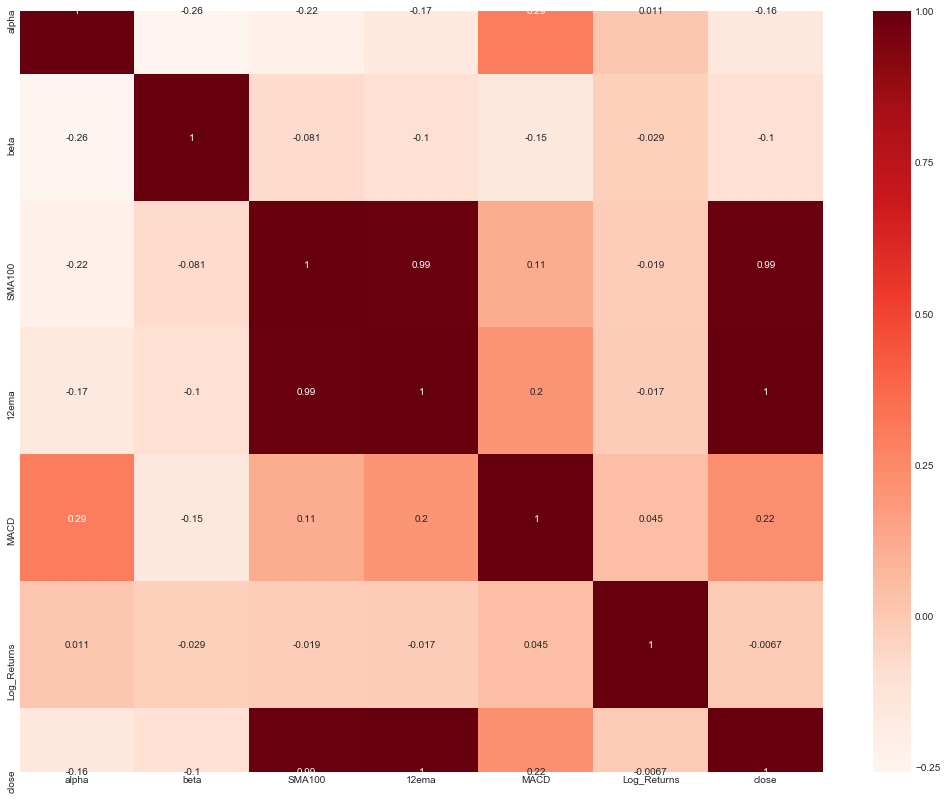

In [363]:
variables_correlation(appl)

In [364]:
def split_data(data):
        total_length = len(data)
        train_index = round(0.8 * total_length)
        
        train = data[:int(train_index), :]
        test = data[int(train_index):, :]
        
        return train, test

In [365]:
print(np.any(np.isnan(appl)))
print(np.all(np.isfinite(appl)))

False
True


In [366]:
appl.head()

,alpha,beta,SMA100,12ema,MACD,Log_Returns,close
Date,,,,,,,
2001-05-25,0.003119,1.630788,1.313010,1.458801,-0.002959,-0.019148,1.414536
2001-05-29,0.002948,1.635992,1.316177,1.439656,-0.012667,-0.058348,1.334362
2001-05-30,0.002236,1.658992,1.317866,1.407298,-0.028507,-0.081985,1.229328
2001-05-31,0.001228,1.708568,1.320088,1.381544,-0.039749,0.008558,1.239894
2001-06-01,0.001618,1.678210,1.322777,1.368739,-0.043444,0.046042,1.298315


In [367]:
appl.tail()

,alpha,beta,SMA100,12ema,MACD,Log_Returns,close
Date,,,,,,,
2019-08-05,-0.000492,1.587492,194.969472,203.679869,1.389810,-0.053768,192.031647
2019-08-06,-0.000501,1.620263,195.108275,202.447102,0.647648,0.018753,195.666885
2019-08-07,-0.000426,1.603469,195.243692,201.715715,0.220437,0.010302,197.693085
2019-08-08,-0.000277,1.605457,195.403913,201.767663,0.231044,0.021816,202.053375
2019-08-09,-0.000446,1.570014,195.562227,201.555466,0.103901,-0.008275,200.388382


In [368]:
appl.describe()

,alpha,beta,SMA100,12ema,MACD,Log_Returns,close
count,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000
mean,0.000966,1.173952,53.776219,55.653345,0.305532,0.001077,55.893626
std,0.002443,0.427232,56.667325,58.365629,1.598309,0.022293,58.598945
min,-0.006510,0.036292,0.896770,0.843522,-10.698082,-0.197470,0.815409
25%,-0.000453,0.885850,6.842763,7.311093,-0.062823,-0.009538,7.403627
50%,0.000856,1.111475,30.050067,31.747886,0.108090,0.000942,31.978696
75%,0.002430,1.411283,94.224057,92.308400,0.728706,0.012190,92.593307
max,0.010667,2.801543,205.928441,221.371325,7.084879,0.130194,227.839798


In [369]:
columns = list(appl.columns)
print(columns)

['alpha', 'beta', 'SMA100', '12ema', 'MACD', 'Log_Returns', 'close']


In [370]:
train, test = split_data(appl.values)

In [371]:
print("Train: ", np.any(np.isnan(appl)))
print("Train: ", np.all(np.isfinite(appl)))

print("Test: ", np.any(np.isnan(test)))
print("Test: ", np.all(np.isfinite(test)))

Train:  False
Train:  True
Test:  False
Test:  True


In [372]:
def normalize_data(train, test):
        normalizer = preprocessing.Normalizer()
        train = normalizer.fit_transform(train)
        test = normalizer.transform(test)        
        return train, test

In [373]:
train, test = normalize_data(train, test)

In [374]:
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (3664, 7)
Test data shape:  (916, 7)


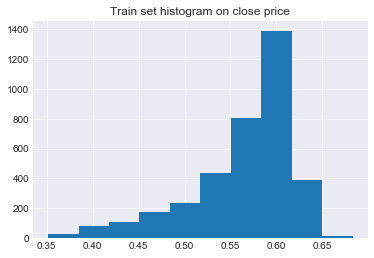

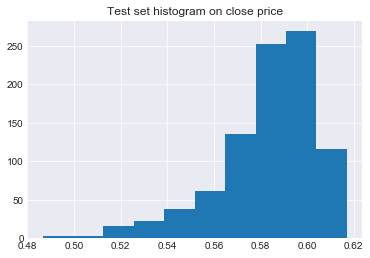

In [375]:
plt.hist(train[:,-1])
plt.title("Train set histogram on close price") 
plt.show()

plt.hist(test[:,-1])
plt.title("Test set histogram on close price") 
plt.show()

In [376]:
reg = ensemble.GradientBoostingRegressor()
X = train[:, :-1]
y = train[:, -1]
reg.fit(X, y)
print(reg.score(X, y))
print(reg.feature_importances_)

reg = linear_model.LinearRegression().fit(X, y)
print(reg.score(X, y))

Xt = test[:, :-1]
yt = test[:, -1]
pred = reg.predict(Xt)
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

cofs = []

for index in range(len(columns) - 1):
    cofs.append((columns[index], reg.coef_[index]))
    
srt = sorted(cofs, key=lambda tup: tup[1])
print(srt)


0.9848524555035472
[0.0017985  0.04268089 0.06243748 0.80709403 0.06939916 0.01658994]
0.9514970267954828
Mean Squared Error:  7.96202775126164e-05
[('beta', -0.10400312724370417), ('SMA100', -0.06161371765330266), ('12ema', 0.5172340621939717), ('Log_Returns', 0.9717674204370271), ('MACD', 1.121067084192122), ('alpha', 7.0187322028818135)]


In [377]:
def formate_data(data, x_len, y_len):
        x_s = []
        y_s = []
        
        for index in range(len(data) - (x_len + y_len)):
            # We delete the close price from the xs
            x_s.append(data[index: (index + x_len), :-1])
            # We just want the close price as target variable
            y_s.append(data[(index + x_len):(index + x_len + y_len), -1])
        
        x_s = np.array(x_s)
        y_s = np.array(y_s)
        
        return x_s, y_s

In [33]:
def formate_data(xs, ys, x_len, y_len):
        x_s = []
        y_s = []
        
        for index in range(len(xs) - (x_len + y_len)):
            # We delete the close price from the xs
            x_s.append(xs[index: (index + x_len), :])
            # We just want the close price as target variable
            y_s.append(ys[(index + x_len):(index + x_len + y_len)])
        
        x_s = np.array(x_s)
        y_s = np.array(y_s)
        
        return x_s, y_s

In [378]:
x_train, y_train = formate_data(train, 24, 7)
x_test, y_test = formate_data(test, 24, 7)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

print("X test shape:", x_test.shape)
print("Y test shape:", y_test.shape)

X train shape: (3633, 24, 6)
Y train shape: (3633, 7)
X test shape: (885, 24, 6)
Y test shape: (885, 7)


In [320]:
#clf = linear_model.MultiTaskLassoCV(cv=5)

# Set a minimum threshold of 0.25
#sfm = feature_selection.SelectFromModel(clf, threshold=0.05)
#sfm.fit(np.reshape(x_train, (3633, 24 * 21)), y_train)
#x_train = sfm.transform(x_train)
#x_test = sfm.transform(x_test)

#print("After Selection train (X) data shape: ", x_train.shape)
#print("After Selection test (X) data shape: ", x_test.shape)
print("Skip")

Skip


In [379]:
X = np.reshape(x_train, (3633, 24 * 6))
y = y_train
reg = linear_model.LinearRegression().fit(X, y)
print(reg.score(X, y))

0.9280018770388291


In [381]:
Xt = np.reshape(x_test, (885, 24 * 6))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [382]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  9.42471140316799e-05


In [383]:
def plot_results_against_true_data(tested_data, true_data, title="Results comparison"):
        plt.figure(figsize = (15,6))
        # style
        plt.style.use('seaborn-darkgrid')

        plt.plot(
            range(len(tested_data)), 
            tested_data, 
            marker='', 
            color="blue", 
            linewidth=0.5, 
            alpha=1, 
            label="Predicted Data"
        )

        plt.plot(
            range(len(true_data)), 
            true_data, 
            marker='', 
            color="black", 
            linewidth=0.5, 
            alpha=0.8, 
            label="Real Data"
        )

        plt.legend(loc=2, ncol=2)
        plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.show()

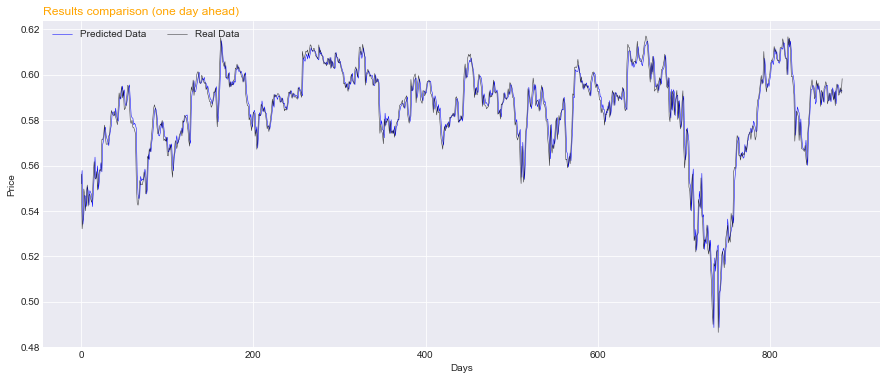

In [384]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

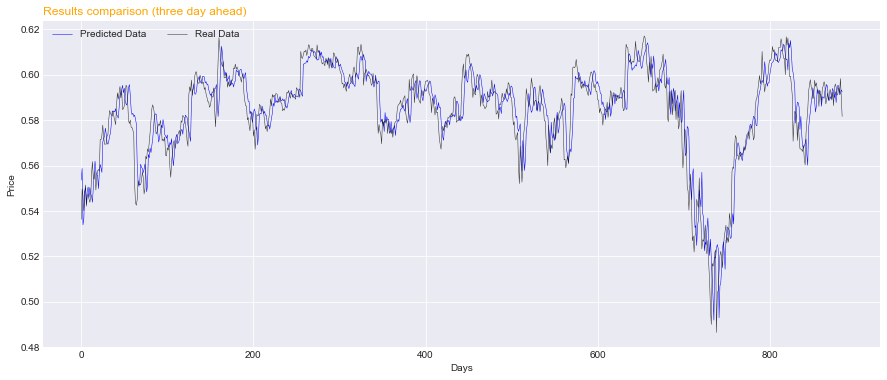

In [385]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three day ahead)")

In [386]:
print(pred[:,0].max())

0.6157717519928879


In [387]:
Xt = np.reshape(x_test, (885, 24 * 6))
yt = y_test

In [60]:
test = {
    'estimator__learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
    'estimator__n_estimators':[1250,1500,1750,2000]
}

reg = ensemble.GradientBoostingRegressor(
    random_state=10,   
    alpha=0.9,
    criterion='friedman_mse',
    init=None,
    loss='ls', max_depth=4,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_iter_no_change=None,
    presort='auto',
    subsample=1,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False)
model = multioutput.MultiOutputRegressor(reg, n_jobs=-1)
tuning = model_selection.GridSearchCV(estimator=model, param_grid = test, iid=False, cv=5)
tuning.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                                                criterion='friedman_mse',
                                                                                init=None,
                                                                                learning_rate=0.1,
                                                                                loss='ls',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                    

In [61]:
tuning.best_estimator_

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.05,
                                                         loss='ls', max_depth=4,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_

In [388]:
test = { 
    'estimator__max_depth': np.linspace(1, 10, 10, endpoint=True)
}

reg = ensemble.GradientBoostingRegressor(
    alpha=0.9,
    criterion='friedman_mse',
    init=None,
    learning_rate=0.05,
    max_features='sqrt',
    loss='ls',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=2000,
    n_iter_no_change=None,
    presort='auto',
    random_state=10,
    subsample=1,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False)
model = multioutput.MultiOutputRegressor(reg, n_jobs=-1)
tuning = model_selection.GridSearchCV(estimator=model, param_grid = test, iid=False, cv=5)
tuning.fit(X, y)

KeyboardInterrupt: 

In [86]:
tuning.best_estimator_

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.05,
                                                         loss='ls',
                                                         max_depth=7.0,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,


In [87]:
test = {
    'estimator__min_samples_split': [2, 3, 4],
    'estimator__min_samples_leaf': [1, 2, 3, 4]
}

reg = ensemble.GradientBoostingRegressor(
    alpha=0.9,
    criterion='friedman_mse',
    init=None,
    learning_rate=0.05,
    max_features='sqrt',
    max_depth=7.0,
    loss='ls',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_weight_fraction_leaf=0.0,
    n_estimators=2000,
    n_iter_no_change=None,
    presort='auto',
    random_state=10,
    subsample=1,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False)

model = multioutput.MultiOutputRegressor(reg, n_jobs=-1)
tuning = model_selection.GridSearchCV(estimator=model, param_grid = test, iid=False, cv=5)
tuning.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                                                criterion='friedman_mse',
                                                                                init=None,
                                                                                learning_rate=0.05,
                                                                                loss='ls',
                                                                                max_depth=7.0,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                 

In [88]:
tuning.best_estimator_

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.05,
                                                         loss='ls',
                                                         max_depth=7.0,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,


In [89]:
test = {
    'estimator__max_features': ['sqrt', 'auto', 'log2']
}

reg = ensemble.GradientBoostingRegressor(
    alpha=0.9,
    criterion='friedman_mse',
    init=None,
    learning_rate=0.05,
    max_depth=7.0,
    loss='ls',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_weight_fraction_leaf=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=2000,
    n_iter_no_change=None,
    presort='auto',
    random_state=10,
    subsample=1,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False)

model = multioutput.MultiOutputRegressor(reg, n_jobs=-1)
tuning = model_selection.GridSearchCV(estimator=model,param_grid=test, iid=False, cv=5)
tuning.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                                                criterion='friedman_mse',
                                                                                init=None,
                                                                                learning_rate=0.05,
                                                                                loss='ls',
                                                                                max_depth=7.0,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                   

In [90]:
tuning.best_estimator_

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.05,
                                                         loss='ls',
                                                         max_depth=7.0,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,


In [48]:
def tune_lr(x, y, x_test, y_test):
    l_rates = [0.25, 0.1, 0.05, 0.01]
    train_results = []
    test_results = []
    
    for eta in l_rates:
        reg = ensemble.GradientBoostingRegressor(learning_rate=eta)
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(l_rates, train_results, 'b', label="Train MSE")
    line2, = plt.plot(l_rates, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('l_rate')
    plt.show()

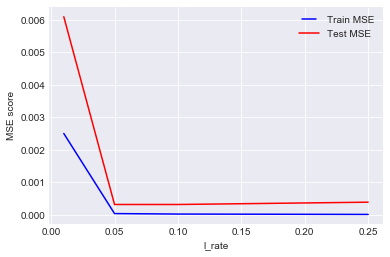

In [49]:
tune_lr(X, y, Xt, yt)

In [50]:
def tune_estimators(x, y, x_test, y_test):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 300, 400] # 100
    train_results = []
    test_results = []
    
    for estimator in n_estimators:
        print("Estimator: ", estimator)
        reg = ensemble.GradientBoostingRegressor(learning_rate=0.05, n_estimators=estimator)
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train MSE")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('n_estimators')
    plt.show()

Estimator:  1
Estimator:  2
Estimator:  4
Estimator:  8
Estimator:  16
Estimator:  32
Estimator:  64
Estimator:  100
Estimator:  300
Estimator:  400


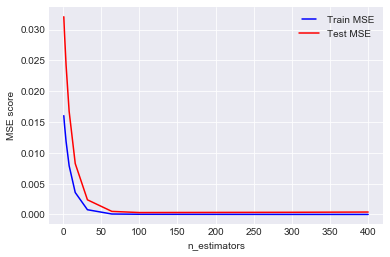

In [51]:
tune_estimators(X, y, Xt, yt)

In [52]:
def max_depth(x, y, x_test, y_test):
    max_depths = np.linspace(1, 12, 12, endpoint=True)
    train_results = []
    test_results = []
    
    for max_depth in max_depths:
        print("Max depth: ", max_depth)
        reg = ensemble.GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=max_depth)
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train MSE")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('max_depth')
    plt.show()

Max depth:  1.0
Max depth:  2.0
Max depth:  3.0
Max depth:  4.0
Max depth:  5.0
Max depth:  6.0
Max depth:  7.0
Max depth:  8.0
Max depth:  9.0
Max depth:  10.0
Max depth:  11.0
Max depth:  12.0


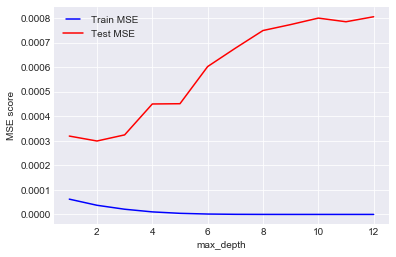

In [53]:
max_depth(X, y, Xt, yt)

In [54]:
def min_samples_split(x, y, x_test, y_test):
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_split in min_samples_splits:
        print("Min Samples Split: ", min_samples_split)
        reg = ensemble.GradientBoostingRegressor(
            n_estimators=200, 
            learning_rate=0.05, 
            max_depth=2.0, 
            min_samples_split=min_samples_split
        )
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train MSE")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('min_samples_splits')
    plt.show()

Min Samples Split:  0.1
Min Samples Split:  0.2
Min Samples Split:  0.30000000000000004
Min Samples Split:  0.4
Min Samples Split:  0.5
Min Samples Split:  0.6
Min Samples Split:  0.7000000000000001
Min Samples Split:  0.8
Min Samples Split:  0.9
Min Samples Split:  1.0


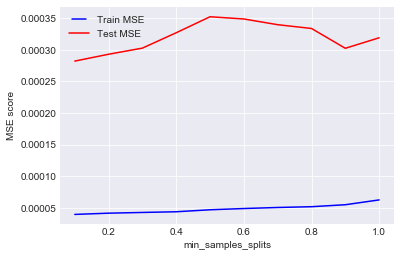

In [55]:
min_samples_split(X, y, Xt, yt)

In [56]:
def min_samples_leaf(x, y, x_test, y_test):
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

    train_results = []
    test_results = []
    
    for min_samples_leaf in min_samples_leafs:
        print("Min Samples Leaf: ", min_samples_leaf)
        reg = ensemble.GradientBoostingRegressor(
            n_estimators=200, 
            learning_rate=0.05, 
            max_depth=2.0,
            min_samples_leaf=min_samples_leaf
        )
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train MSE")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('min_samples_leaf')
    plt.show()

Min Samples Leaf:  0.1
Min Samples Leaf:  0.2
Min Samples Leaf:  0.30000000000000004
Min Samples Leaf:  0.4
Min Samples Leaf:  0.5


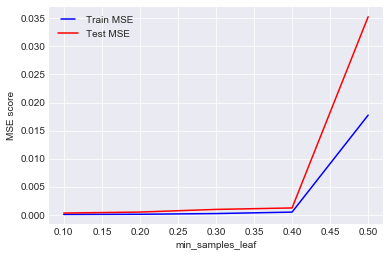

In [57]:
min_samples_leaf(X, y, Xt, yt)

In [74]:
def max_features(x, y, x_test, y_test):
    max_features = list(range(1, 25))

    train_results = []
    test_results = []
    
    for max_feature in max_features:
        print("Max Feature: ", max_feature)
        reg = ensemble.GradientBoostingRegressor(
            n_estimators=300, 
            learning_rate=0.05, 
            max_depth=6.0, 
            min_samples_split=0.2,
            min_samples_leaf=0.4,
            max_features=max_feature
        )
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_features, train_results, 'b', label="Train MSE")
    line2, = plt.plot(max_features, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('max_features')
    plt.show()

Max Feature:  1
Max Feature:  2
Max Feature:  3
Max Feature:  4
Max Feature:  5
Max Feature:  6
Max Feature:  7
Max Feature:  8
Max Feature:  9
Max Feature:  10
Max Feature:  11
Max Feature:  12
Max Feature:  13
Max Feature:  14
Max Feature:  15
Max Feature:  16
Max Feature:  17
Max Feature:  18
Max Feature:  19
Max Feature:  20
Max Feature:  21
Max Feature:  22
Max Feature:  23
Max Feature:  24


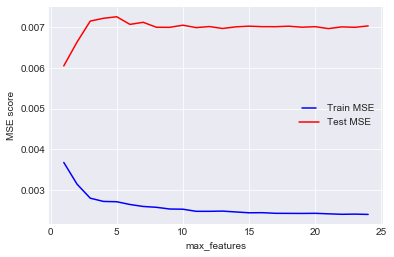

In [75]:
max_features(X, y, Xt, yt)

In [389]:
reg = ensemble.GradientBoostingRegressor(alpha=0.9,
                                         criterion='friedman_mse',
                                         init=None,
                                         learning_rate=0.05,
                                         loss='ls',
                                         max_depth=7.0,
                                         max_features='sqrt',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=2000,
                                         n_iter_no_change=None,
                                         presort='auto',
                                         random_state=10,
                                         subsample=1,
                                         tol=0.0001,
                                         validation_fraction=0.1,
                                         verbose=0,
                                         warm_start=False)
reg = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(X, y)
print(reg.score(X, y))

0.9999673487389177


In [390]:
Xt = np.reshape(x_test, (885, 24 * 6))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [391]:
mse = metrics.mean_squared_error(yt, pred)
print("Score: ", reg.score(Xt, pred))
print("Mean Squared Error: ", mse)

Score:  1.0
Mean Squared Error:  0.0001542448670688635


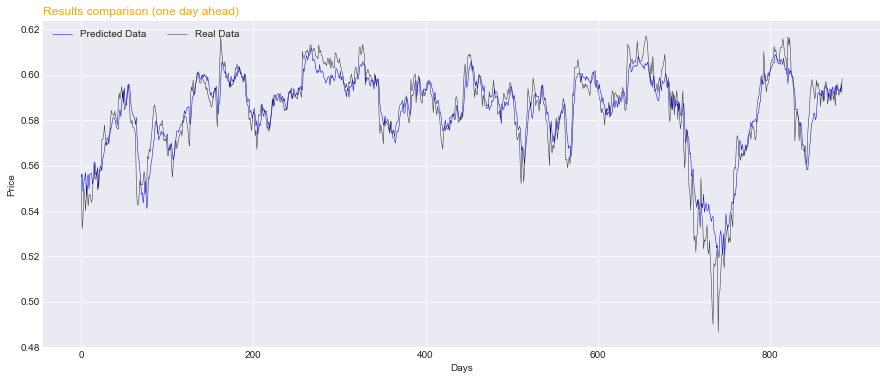

In [392]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

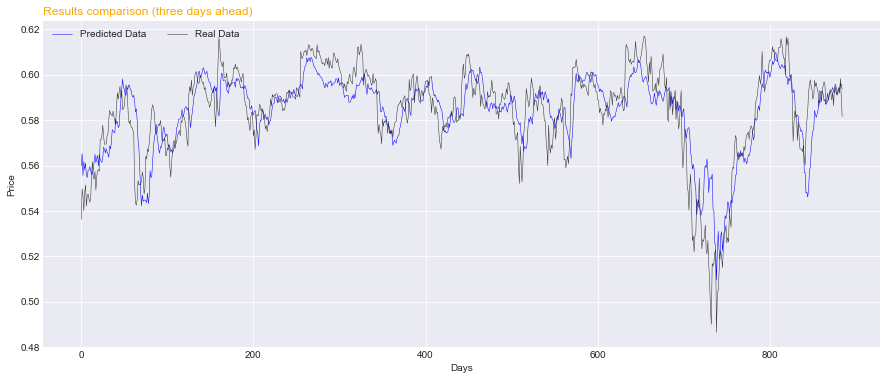

In [393]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three days ahead)")

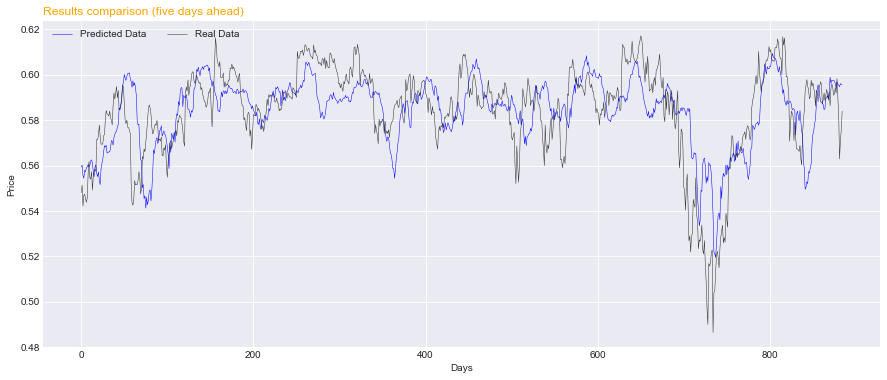

In [394]:
plot_results_against_true_data(pred[:,6], yt[:,6], title="Results comparison (five days ahead)")

In [63]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

X = np.reshape(x_train, (3633, 24 * 13))
y = y_train

test = {
    'n_neighbors': [10,20,50,75,100,200,300], 
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[10,15,20,25,30,35,40,50,100]
}

model = neighbors.KNeighborsRegressor()
tuning = model_selection.GridSearchCV(estimator=model,param_grid=test,iid=False, cv=5)
tuning.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 15, 20, 25, 30, 35, 40, 50, 100],
                         'n_neighbors': [10, 20, 50, 75, 100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [64]:
tuning.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform')

In [395]:
reg = neighbors.KNeighborsRegressor(
    algorithm='auto', 
    leaf_size=10, 
    metric='minkowski',
    metric_params=None, 
    n_jobs=None, 
    n_neighbors=20, 
    p=2,
    weights='uniform'
).fit(X, y)
print(reg.score(X, y))

0.9340020345788006


In [396]:
Xt = np.reshape(x_test, (885, 24 * 6))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [397]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.00021395082387441695


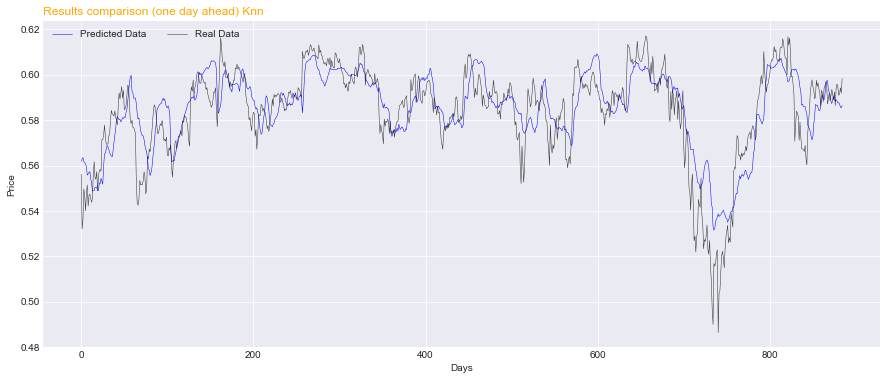

In [398]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead) Knn")

In [399]:
from tensorflow.keras.layers import Activation, Dense, GRU
from tensorflow.keras.models import Sequential

In [400]:
def build(amount_of_features, seq_len):
            
        model = Sequential()

        model.add(GRU(
            units=256,
            activation="tanh",
            return_sequences=True,
            dropout=0.2,
            input_shape=(seq_len, amount_of_features)
            )
        )

        model.add(GRU(
            units=256,
            activation="tanh",
            return_sequences=False,
            dropout=0.2
            )
        )

        model.add(Dense(64, activation="relu"))
        model.add(Dense(7, activation="linear"))

        model.summary()

        model.compile(
            optimizer="Nadam",
            loss="mse"
        )

        return model

In [401]:
reg = build(6, 24)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 24, 256)           201984    
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 455       
Total params: 612,871
Trainable params: 612,871
Non-trainable params: 0
_________________________________________________________________


In [402]:
def train_model(
        model, 
        x_train, 
        y_train,
        batch_size,
        epochs
    ):
    
        history = model.fit(
            x=x_train, 
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.1,
            shuffle=False
        )

        return history, model

In [403]:
hist, model = train_model(reg, x_train, y_train, 256, 200)

Train on 3269 samples, validate on 364 samples
Epoch 1/200
3269/3269 [==============================] - 24s 7ms/sample - loss: 0.0709 - val_loss: 9.2172e-04
Epoch 2/200
3269/3269 [==============================] - 16s 5ms/sample - loss: 0.0314 - val_loss: 6.5106e-04
Epoch 3/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0202 - val_loss: 6.2757e-04
Epoch 4/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0133 - val_loss: 5.8795e-04
Epoch 5/200
3269/3269 [==============================] - 16s 5ms/sample - loss: 0.0096 - val_loss: 6.3877e-04
Epoch 6/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0071 - val_loss: 5.9416e-04
Epoch 7/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0049 - val_loss: 5.3181e-04
Epoch 8/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0035 - val_loss: 2.9010e-04
Epoch 9/200
3269/3269 [==============================] - 15s 5ms/sample -

Epoch 77/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0011 - val_loss: 0.0025
Epoch 78/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0011 - val_loss: 0.0031
Epoch 79/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0011 - val_loss: 0.0029
Epoch 80/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0011 - val_loss: 0.0030
Epoch 81/200
3269/3269 [==============================] - 15s 4ms/sample - loss: 0.0011 - val_loss: 0.0035
Epoch 82/200
3269/3269 [==============================] - 15s 4ms/sample - loss: 0.0012 - val_loss: 0.0028
Epoch 83/200
3269/3269 [==============================] - 15s 5ms/sample - loss: 0.0011 - val_loss: 0.0036
Epoch 84/200
3269/3269 [==============================] - 15s 4ms/sample - loss: 0.0010 - val_loss: 0.0034
Epoch 85/200
3269/3269 [==============================] - 15s 4ms/sample - loss: 0.0010 - val_loss: 0.0033
Epoch 86/200
3269/3269 [=============

In [404]:
scores = model.evaluate(x_test, y_test, verbose=0)
print(scores)

0.006530925340550599


In [405]:
results = model.predict(x_test)
print(results.shape)

(885, 7)


In [406]:
mse = metrics.mean_squared_error(y_test, results)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.006530925346784497


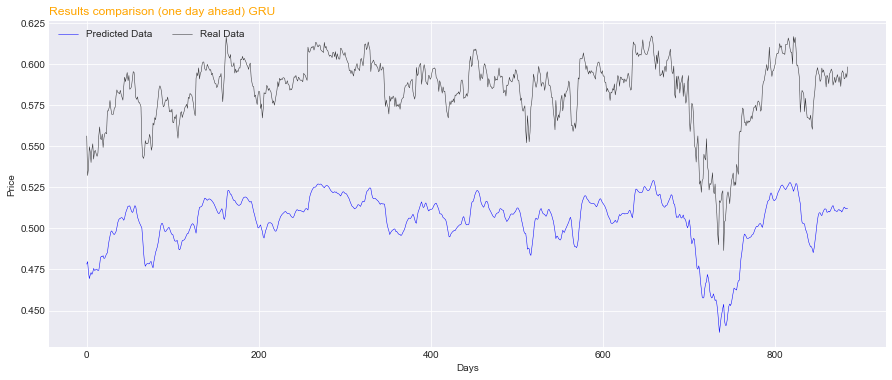

In [407]:
plot_results_against_true_data(results[:,0], y_test[:,0], title="Results comparison (one day ahead) GRU")